# Preamble

In [1]:
import numpy as np
import numba
import matplotlib.pyplot as plt
import seaborn as sns
import pet_cli.graphical_analysis as pet_grph
import nibabel
import json

sns.set()
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.4)
plt.rcParams['font.family'] ='StixGeneral'
plt.rcParams['mathtext.fontset'] = 'stix'

PET Processing Package


/Users/furqandar/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


$$\require{mchem}$$

# Loading Data & Resampling Plasma TAC (pTAC)

## Loading In A 4D-PET Image

In [8]:
DATA_DIR = '../../../../PracticeData/'

In [193]:
pet_img = nibabel.load(f"{DATA_DIR}/4DPET/1179307_v2_FDG_on_mpr.nii.gz")

In [194]:
type(pet_img)

nibabel.nifti1.Nifti1Image

In [152]:
img_vals = pet_img.get_fdata()/37000.
xDim, yDim, zDim, tDim = img_vals.shape
img_vals.shape

(176, 240, 256, 52)

## Loading Arterial Input Function

In [18]:
arterial_input_function = np.loadtxt(f"{DATA_DIR}BloodData_CMS/1179307_v2.csv", skiprows=1, delimiter=',')

aif_tac   = np.array([arterial_input_function[:,1], arterial_input_function[:,-1]], 
                                   order="C", dtype='float')

aif_tac

array([[3.73330e-06, 2.16670e-01, 3.83340e-01, 6.66670e-01, 8.83340e-01,
        1.05000e+00, 1.25000e+00, 1.41670e+00, 1.60000e+00, 1.78330e+00,
        2.03334e+00, 2.18334e+00, 2.31667e+00, 2.46667e+00, 2.61667e+00,
        2.85000e+00, 3.06667e+00, 3.33334e+00, 3.58334e+00, 3.81667e+00,
        4.08334e+00, 4.33334e+00, 4.58334e+00, 4.83334e+00, 5.33334e+00,
        5.75000e+00, 6.70000e+00, 7.71667e+00, 8.71667e+00, 9.70000e+00,
        1.07000e+01, 1.27000e+01, 1.57000e+01, 2.06500e+01, 2.56500e+01,
        3.06500e+01, 3.56500e+01, 4.56500e+01, 6.06500e+01],
       [6.22500e-05, 6.75620e-05, 1.21810e+00, 2.21840e+00, 8.36830e-01,
        6.13820e-01, 5.24330e-01, 4.76340e-01, 4.65450e-01, 4.67900e-01,
        4.70964e-01, 4.30692e-01, 4.55850e-01, 4.38788e-01, 4.30899e-01,
        4.23412e-01, 4.02504e-01, 3.87883e-01, 3.87879e-01, 3.80343e-01,
        3.71751e-01, 3.61616e-01, 3.59765e-01, 3.55952e-01, 3.46931e-01,
        3.35135e-01, 3.19147e-01, 3.09760e-01, 2.94450e-01, 2.8

### Plotting pTAC

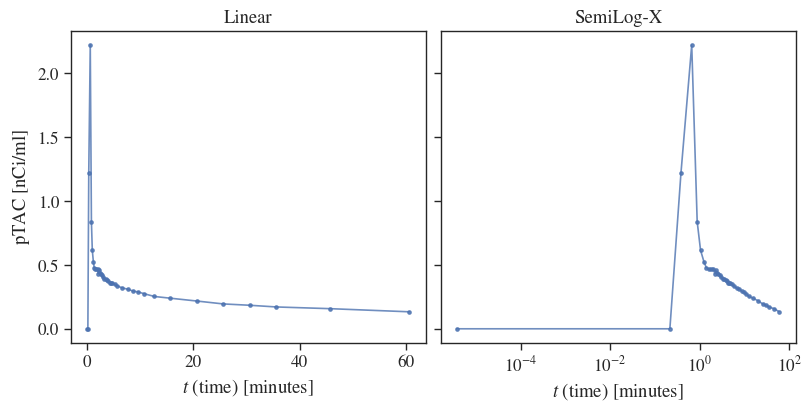

In [51]:
myFig, myAx = plt.subplots(1,2, constrained_layout=True, figsize=[8,4], sharey=True)
for anAx in myAx.flatten():
    anAx.plot(*aif_tac, '.-', alpha=0.8)
    anAx.set(xlabel=r'$t$ (time) [minutes]')
myAx[0].set(ylabel=r'pTAC [$\mathrm{n Ci / ml}$]', title='Linear')
myAx[1].set(xscale='log', title='SemiLog-X')

plt.show()

## Resampling pTAC At Scanner Frame Times

### Loading In Scanner Frame Times

In [40]:
scanner_times = []
with open("../../../../PracticeData/ScannerFrameTimes_CMS/1179307_v2_info.json") as dFile:
    scanner_times = np.array(json.load(dFile)['FrameReferenceTime'], order='C', dtype=float)/60.
scanner_times

array([2.49981667e-02, 1.08331500e-01, 1.91665000e-01, 2.74998333e-01,
       3.58331667e-01, 4.41665000e-01, 5.24998333e-01, 6.08331667e-01,
       6.91665000e-01, 7.74998333e-01, 8.58331667e-01, 9.41665000e-01,
       1.02499833e+00, 1.10833167e+00, 1.19166500e+00, 1.27499833e+00,
       1.35833167e+00, 1.44166500e+00, 1.52499833e+00, 1.60833167e+00,
       1.69166667e+00, 1.77500000e+00, 1.85833333e+00, 1.94166667e+00,
       2.14996667e+00, 2.48330000e+00, 2.81663333e+00, 3.14996667e+00,
       3.48330000e+00, 3.81663333e+00, 4.14996667e+00, 4.48330000e+00,
       4.81663333e+00, 5.48306667e+00, 6.48306667e+00, 7.48306667e+00,
       8.48306667e+00, 9.48306667e+00, 1.04830667e+01, 1.14830667e+01,
       1.24830667e+01, 1.34830667e+01, 1.44830667e+01, 1.74768333e+01,
       2.24768333e+01, 2.74768333e+01, 3.24768333e+01, 3.74768333e+01,
       4.24768333e+01, 4.74768333e+01, 5.24768333e+01, 5.74768333e+01])

### Interpolating pTAC On Scanner Frame Times

In [41]:
from pet_cli.blood_input import BloodInputFunction

In [42]:
scanner_aif = BloodInputFunction(time=aif_tac[0], activity=aif_tac[1], thresh_in_mins=30.0)
aif_on_scanner_tac = np.array([scanner_times, scanner_aif.calc_blood_input_function(x=scanner_times)],
                           dtype=float, order='C')

### Plotting Resampled pTAC

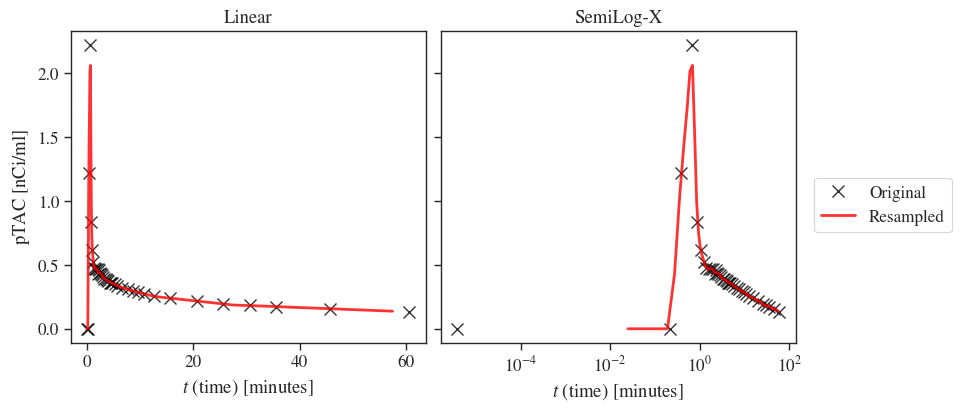

In [53]:
myFig, myAx = plt.subplots(1,2, constrained_layout=True, figsize=[8,4], sharey=True)
for anAx in myAx.flatten():
    anAx.plot(*aif_tac, 'x', alpha=0.8, label='Original', color='black', ms=8)
    anAx.plot(*aif_on_scanner_tac, '-', alpha=0.8, label='Resampled', color='red', lw=2)
    anAx.set(xlabel=r'$t$ (time) [minutes]')
    
    

myAx[0].set(ylabel=r'pTAC [$\mathrm{n Ci / ml}$]', title='Linear')
myAx[1].set(xscale='log', title='SemiLog-X')
myFig.legend(*myAx[0].get_legend_handles_labels(), bbox_to_anchor=(1.0, 0.5), loc='center left')

plt.show()

### Saving Resampled pTAC To File

In [55]:
np.savetxt(fname="../../../../PracticeData/4DPET/1179307_v2_pTAC_resampled_on_scanner_times.txt", 
           X=aif_on_scanner_tac.T,
          header='Time (s), Activity (nCu)', fmt='%.6e')

# Generating Parametric Images: Explicitly Looping Over All Voxels

## Reusing `patlak_analysis` from `graphical_analysis`

In [62]:
@numba.njit()
def gen_patlak_parametric_image(pTAC_times: np.ndarray, pTAC_vals: np.ndarray,
                                tTAC_img, t_thresh_in_mins: float) -> np.ndarray:
    img_dims = tTAC_img.shape
    
    patlak_ki_img = np.zeros((img_dims[0], img_dims[1], img_dims[2]), float)
    patlak_vt_img = np.zeros_like(patlak_ki_img)
    
    for i in range(0, img_dims[0], 1):
        for j in range(0, img_dims[1], 1):
            for k in range(0, img_dims[2], 1):
                patlak_vals = pet_grph.patlak_analysis(input_tac_values=pTAC_vals, 
                                                       region_tac_values=tTAC_img[i,j,k,:],
                                                       tac_times_in_minutes=pTAC_times,
                                                       t_thresh_in_minutes=t_thresh_in_mins)
                patlak_ki_img[i,j,k]=patlak_vals[0]
                patlak_vt_img[i,j,k]=patlak_vals[1]
    return patlak_ki_img, patlak_vt_img

tmp_param_imgs = gen_patlak_parametric_image(pTAC_times=aif_on_scanner_tac[0],
                                             pTAC_vals=aif_on_scanner_tac[1],
                                            tTAC_img=img_vals[xDim//2-10:xDim//2+10, 
                                                              yDim//2-10:yDim//2+10, 
                                                              zDim//2-10:zDim//2+10, :],
                                            t_thresh_in_mins=30.0)

In [95]:
# %%timeit
tmp_param_imgs = gen_patlak_parametric_image(pTAC_times=aif_on_scanner_tac[0],
                                             pTAC_vals=aif_on_scanner_tac[1],
                                            tTAC_img=img_vals,
                                            t_thresh_in_mins=30.0)

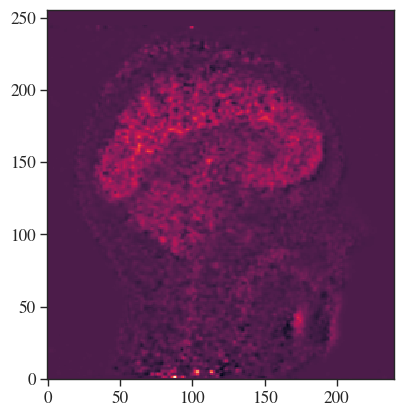

In [65]:
plt.imshow(tmp_param_imgs[0][xDim//2,:,:].T, interpolation='none', origin='lower')
plt.show()

## Testing New Implementation To Take Out Redundant Patlak-X Calculations

In [66]:
@numba.njit()
def gen_patlak_parametric_image_v2(pTAC_times: np.ndarray, pTAC_vals: np.ndarray,
                                tTAC_img, t_thresh_in_mins: float) -> np.ndarray:
    img_dims = tTAC_img.shape
    
    patlak_ki_img = np.zeros((img_dims[0], img_dims[1], img_dims[2]), float)
    patlak_vt_img = np.zeros_like(patlak_ki_img)
    
    t_thresh = pet_grph.get_index_from_threshold(times_in_minutes=pTAC_times, 
                                        t_thresh_in_minutes=t_thresh_in_mins)
    
    patlak_x = pet_grph.calculate_patlak_x(tac_times=pTAC_times, tac_vals=pTAC_vals)
    
    inv_pTAC_vals = 1.0/pTAC_vals[:]
    
    for i in range(0, img_dims[0], 1):
        for j in range(0, img_dims[1], 1):
            for k in range(0, img_dims[2], 1):
                patlak_y = tTAC_img[i,j,k,:]*inv_pTAC_vals[:]
                patlak_vals = pet_grph.fit_line_to_data_using_lls(xdata=patlak_x[t_thresh:], 
                                                                  ydata=patlak_y[t_thresh:])
                patlak_ki_img[i,j,k]=patlak_vals[0]
                patlak_vt_img[i,j,k]=patlak_vals[1]
    return patlak_ki_img, patlak_vt_img

tmp_param_imgs = gen_patlak_parametric_image_v2(pTAC_times=aif_on_scanner_tac[0],
                                             pTAC_vals=aif_on_scanner_tac[1],
                                            tTAC_img=img_vals[xDim//2-10:xDim//2+10, yDim//2-10:yDim//2+10, zDim//2-10:zDim//2+10, :],
                                            t_thresh_in_mins=30.0)

In [96]:
# %%timeit
tmp_param_imgs_v2 = gen_patlak_parametric_image_v2(pTAC_times=aif_on_scanner_tac[0],
                                             pTAC_vals=aif_on_scanner_tac[1],
                                            tTAC_img=img_vals,
                                            t_thresh_in_mins=30.0)

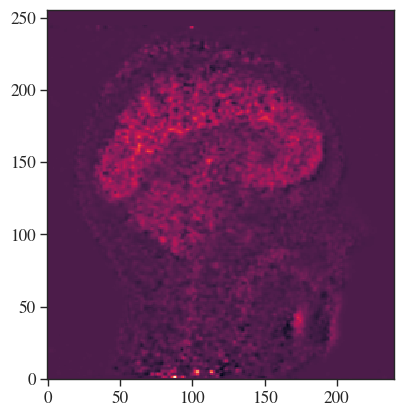

In [97]:
plt.imshow(tmp_param_imgs[0][xDim//2,:,:].T, interpolation='none', origin='lower')
plt.show()

In [77]:
np.allclose(tmp_param_imgs[0] - tmp_param_imgs_v2[0], 0.0)

True

## Testing The Logan Analysis By Reusing `logan_analysis` from `graphical_analysis`

In [136]:
from typing import Tuple
@numba.njit()
def gen_logan_parametric_image(pTAC_times: np.ndarray,
                               pTAC_vals: np.ndarray,
                               tTAC_img,
                               t_thresh_in_mins: float) -> Tuple[np.ndarray, np.ndarray]:
    img_dims = tTAC_img.shape
    
    logan_slope_img = np.zeros((img_dims[0], img_dims[1], img_dims[2]), float)
    logan_intercept_img = np.zeros_like(logan_slope_img)
    
    for i in range(0, img_dims[0], 1):
        for j in range(0, img_dims[1], 1):
            for k in range(0, img_dims[2], 1):
                logan_vals = pet_grph.logan_analysis(input_tac_values=pTAC_vals,
                                                     region_tac_values=tTAC_img[i, j, k, :],
                                                     tac_times_in_minutes=pTAC_times,
                                                     t_thresh_in_minutes=t_thresh_in_mins)
                logan_slope_img[i, j, k] = logan_vals[0]
                logan_intercept_img[i, j, k] = logan_vals[1]
    return logan_slope_img, logan_intercept_img


tmp_param_imgs = gen_logan_parametric_image(pTAC_times=aif_on_scanner_tac[0], 
                                            pTAC_vals=aif_on_scanner_tac[1],
                                            tTAC_img=img_vals[xDim // 2 - 10:xDim // 2 + 10,
                                                              yDim // 2 - 10:yDim // 2 + 10, 
                                                              zDim // 2 - 10:zDim // 2 + 10, :],
                                            t_thresh_in_mins=30.0)

In [150]:
print(img_vals.max())
print(img_vals.min())

49.28864527027027
-5.587725506756756


In [137]:
tmp_param_imgs = gen_logan_parametric_image(pTAC_times=aif_on_scanner_tac[0],
                                            pTAC_vals=aif_on_scanner_tac[1],
                                            tTAC_img=img_vals,
                                            t_thresh_in_mins=30.0)

LinAlgError: Array must not contain infs or NaNs.

We will have to add some division by 0 checks in the logan anal

## Testing A Template-Like Function

In [176]:
from typing import Tuple
@numba.njit()
def gen_parametric_image_with_graphical_method(pTAC_times: np.ndarray,
                                               pTAC_vals: np.ndarray,
                                               tTAC_img: np.ndarray,
                                               t_thresh_in_mins: float,
                                               analysis_func) -> Tuple[np.ndarray, np.ndarray]:
    img_dims = tTAC_img.shape
    
    slope_img = np.zeros((img_dims[0], img_dims[1], img_dims[2]), float)
    intercept_img = np.zeros_like(slope_img)
    
    for i in range(0, img_dims[0], 1):
        for j in range(0, img_dims[1], 1):
            for k in range(0, img_dims[2], 1):
                analysis_vals = analysis_func(input_tac_values=pTAC_vals, 
                                              region_tac_values=tTAC_img[i, j, k, :],
                                              tac_times_in_minutes=pTAC_times,
                                              t_thresh_in_minutes=t_thresh_in_mins)
                slope_img[i, j, k] = analysis_vals[0]
                intercept_img[i, j, k] = analysis_vals[1]
    return slope_img, intercept_img

In [177]:
tmp_patlak_img = gen_parametric_image_with_graphical_method(pTAC_times=aif_on_scanner_tac[0],
                                                            pTAC_vals=aif_on_scanner_tac[1],
                                                            tTAC_img=img_vals,
                                                            t_thresh_in_mins=30.0,
                                                            analysis_func=pet_grph.patlak_analysis)

### Plotting A Histogram Of Slope ($K_1$) Values Over The Brain

In [162]:
brain_mask = nibabel.load(f"{DATA_DIR}/4DPET/1179307_v2_mpr_BET_mask.nii.gz").get_fdata()

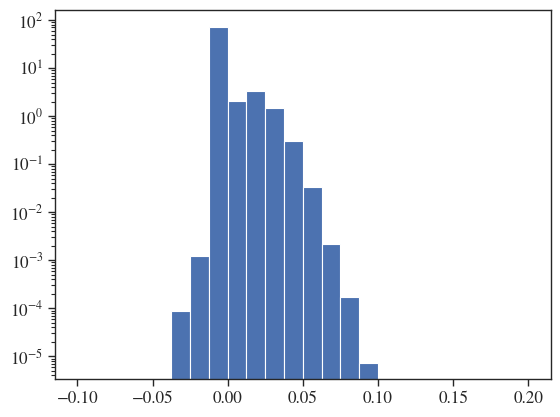

In [163]:
plt.hist((tmp_patlak_img[0]*brain_mask).flatten(), density=True, bins=np.linspace(-0.1, 0.2, 25))
plt.yscale('log')
plt.show()

# Comparing Test Implementation With Package Implementation

In [3]:
import pet_cli.parametric_images as pet_pim

In [179]:
tmp_patlak_img = gen_parametric_image_with_graphical_method(pTAC_times=aif_on_scanner_tac[0],
                                                            pTAC_vals=aif_on_scanner_tac[1],
                                                            tTAC_img=img_vals,
                                                            t_thresh_in_mins=30.0,
                                                            analysis_func=pet_grph.patlak_analysis)

In [181]:
tmp_patlak_img_new = pet_pim.generate_parametric_images_with_graphical_method(pTAC_times=aif_on_scanner_tac[0],
                                                            pTAC_vals=aif_on_scanner_tac[1],
                                                            tTAC_img=img_vals,
                                                            t_thresh_in_mins=30.0,
                                                            method_name='patlak')

In [184]:
np.allclose(tmp_patlak_img[0] - tmp_patlak_img_new [0], 0.0)

True

# Testing Writing Parametric Images Using The Class

In [19]:
from importlib import reload
reload(pet_pim)

<module 'pet_cli.parametric_images' from '/Users/furqandar/Library/Python/3.9/lib/python/site-packages/pet_cli/parametric_images.py'>

In [20]:
patlak_pim = pet_pim.GraphicalAnalysisParametricImage(input_tac_path='../../../../PracticeData/4DPET/1179307_v2_pTAC_resampled_on_scanner_times.txt',
                                                     pet4D_img_path='../../../../PracticeData/4DPET/1179307_v2_FDG_on_mpr.nii.gz',
                                                     output_directory='../../../../PracticeData/4DPET/',
                                                     output_filename_prefix='test')

In [21]:
patlak_pim.run_analysis(method_name='patlak', t_thresh_in_mins=30.0)

/Users/furqandar/Library/Python/3.9/lib/python/site-packages/pet_cli/parametric_images.py:481: UserWarning: PET image values are being divided by 37000 for unit conversion to Bq/cc.
  p_tac_times, p_tac_vals = _safe_load_tac(self.input_tac_path)


In [22]:
patlak_pim.save_parametric_images()
patlak_pim.save_analysis_properties()